# Quantile Power Law Analysis

## Overview

In this notebook we present a Quantile Power Law Analysis. 

In [ ]:
#Import necessary libraries
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import kagglehub



In [ ]:
# Download latest version
path = kagglehub.dataset_download("mczielinski/bitcoin-historical-data")

In [ ]:
# Set the path to the file you'd like to load
file_path = f"{path}/btcusd_1-min_data.csv"

In [37]:
#Read the file
df= pd.read_csv(file_path)

In [38]:
#Check the first few rows of the dataframe
df.head()

,Timestamp,Open,High,Low,Close,Volume
0,1.325412e+09,4.58,4.58,4.58,4.58,0.0
1,1.325412e+09,4.58,4.58,4.58,4.58,0.0
2,1.325412e+09,4.58,4.58,4.58,4.58,0.0
3,1.325412e+09,4.58,4.58,4.58,4.58,0.0
4,1.325412e+09,4.58,4.58,4.58,4.58,0.0


We will study the data summarising at a daily level. We don't need minute by minute data for this analysis. Daily data is sufficient

In [39]:
# Convert Timestamp to datetime if not already
df['Date'] = pd.to_datetime(df['Timestamp'], unit='s').dt.date

# Aggregate to daily data
daily_df = df.groupby('Date').agg({
    'Open': 'first',
    'High': 'max',
    'Low': 'min',
    'Close': 'last',
    'Volume': 'sum'
}).reset_index()

daily_df.head()

,Date,Open,High,Low,Close,Volume
0,2012-01-01,4.58,4.84,4.58,4.84,10.000000
1,2012-01-02,4.84,5.00,4.84,5.00,10.100000
2,2012-01-03,5.00,5.32,5.00,5.29,107.085281
3,2012-01-04,5.29,5.57,4.93,5.57,107.233260
4,2012-01-05,5.57,6.46,5.57,6.42,70.328742


We will now study the data power on the log-log chart. First we set the bitcoin genesis day

In [40]:
#Set bitcoin_genesis date
bitcoin_genesis_date = pd.to_datetime("2010-01-03")

In [41]:
# Add a column for days since Bitcoin Genesis
daily_df['DaysSinceGenesis'] = (pd.to_datetime(daily_df['Date']) - bitcoin_genesis_date).dt.days

In [42]:
daily_df.head() 

,Date,Open,High,Low,Close,Volume,DaysSinceGenesis
0,2012-01-01,4.58,4.84,4.58,4.84,10.000000,728
1,2012-01-02,4.84,5.00,4.84,5.00,10.100000,729
2,2012-01-03,5.00,5.32,5.00,5.29,107.085281,730
3,2012-01-04,5.29,5.57,4.93,5.57,107.233260,731
4,2012-01-05,5.57,6.46,5.57,6.42,70.328742,732


We will add columns for log of the close price and number of days since genesis of the first block

In [43]:
daily_df["log_Close"] = np.log(daily_df["Close"])
daily_df["log_days_since_genesis"] = np.log(daily_df["DaysSinceGenesis"])

We will now plot the data on the log-log scale where we see the data forms a straight line

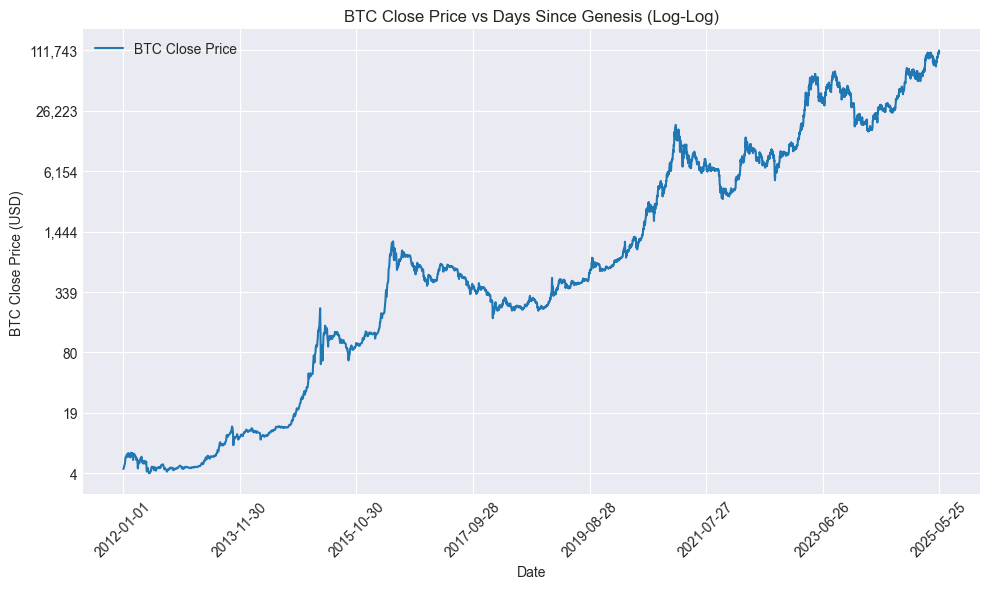

In [44]:
fig, ax = plt.subplots(figsize=(10, 6))

# Plot log-log data
ax.plot(daily_df['log_days_since_genesis'], daily_df['log_Close'], label='BTC Close Price')

# Set x-ticks to show dates
xticks = np.linspace(daily_df['log_days_since_genesis'].min(), daily_df['log_days_since_genesis'].max(), 8)
xtick_labels = pd.to_datetime(daily_df['Date'].iloc[np.linspace(0, len(daily_df)-1, 8, dtype=int)]).dt.strftime('%Y-%m-%d')
ax.set_xticks(xticks)
ax.set_xticklabels(xtick_labels, rotation=45)

# Set y-ticks to show prices
yticks = np.linspace(daily_df['log_Close'].min(), daily_df['log_Close'].max(), 8)
ytick_labels = [f"{np.exp(y):,.0f}" for y in yticks]
ax.set_yticks(yticks)
ax.set_yticklabels(ytick_labels)

ax.set_xlabel('Date')
ax.set_ylabel('BTC Close Price (USD)')
ax.set_title('BTC Close Price vs Days Since Genesis (Log-Log)')
ax.legend()
plt.tight_layout()
plt.show()

We will now run quantile analysis. Quantile analysis makes good sense for bitcoin as it varies a lot. We will use quantiles to show that bitcoin prices in USD varies a lot but can be captured by quantile regression.

In [45]:
import statsmodels.api as sm


# Drop any rows with NaN values
daily_df.dropna(subset=["log_Close", "log_days_since_genesis"], inplace=True)

Y = daily_df["log_Close"]
X = daily_df["log_days_since_genesis"]

# Add a constant to the independent variable for the intercept
X_const = sm.add_constant(X)

# Define the quantiles to be used
quantiles = [0.01, 0.05, 0.25, 0.50, 0.75, 0.95, 0.99]

quantile_regression_results = {}

for q in quantiles:
    # Fit the QuantReg model
    quant_reg_model = sm.QuantReg(Y, X_const).fit(q=q)
    
    # Store the parameters (intercept and slope)
    quantile_regression_results[str(q)] = {
        "intercept": quant_reg_model.params["const"],
        "slope": quant_reg_model.params["log_days_since_genesis"],
        "summary": quant_reg_model.summary().as_text() # Storing full summary for reference
    }


Printing the quantiles here.

In [46]:
print("Quantile Regression Results:")
for q, res in quantile_regression_results.items():
    print(f"Quantile: {q}")
    print(f"Intercept: {res['intercept']}")
    print(f"Slope: {res['slope']}")
    print(f"Summary:\n{res['summary']}")

Quantile Regression Results:
Quantile: 0.01
Intercept: -34.20304053671316
Slope: 5.190474671689856
Summary:
                         QuantReg Regression Results                          
Dep. Variable:              log_Close   Pseudo R-squared:               0.8489
Model:                       QuantReg   Bandwidth:                      0.2431
Method:                 Least Squares   Sparsity:                        4.081
Date:                Sun, 25 May 2025   No. Observations:                 4894
Time:                        21:29:02   Df Residuals:                     4892
                                        Df Model:                            1
                             coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------
const                    -34.2030      0.064   -531.056      0.000     -34.329     -34.077
log_days_since_genesis     5.1905      0.008    642.141      0.000

Plotting the quantiles for visualisation

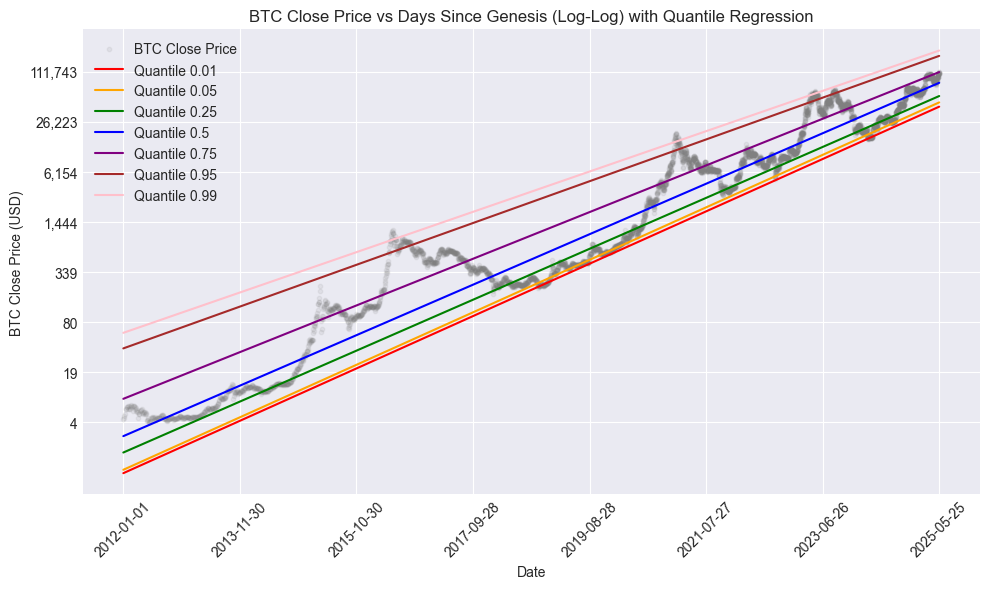

In [47]:
fig, ax = plt.subplots(figsize=(10, 6))
plt.style.use("seaborn-v0_8-darkgrid")

# Plot the actual log-log data
ax.scatter(daily_df['log_days_since_genesis'], daily_df['log_Close'], label='BTC Close Price', color='grey', alpha=0.1, s=10)

# Plot quantile regression lines
quantile_colors = ['red', 'orange', 'green', 'blue', 'purple', 'brown', 'pink']
for i, q in enumerate(quantiles):
    intercept = quantile_regression_results[str(q)]['intercept']
    slope = quantile_regression_results[str(q)]['slope']
    y_pred = intercept + slope * daily_df['log_days_since_genesis']
    ax.plot(daily_df['log_days_since_genesis'], y_pred, label=f'Quantile {q}', color=quantile_colors[i % len(quantile_colors)])

# Set x-ticks to show dates
ax.set_xticks(xticks)
ax.set_xticklabels(xtick_labels, rotation=45)

# Set y-ticks to show prices
ax.set_yticks(yticks)
ax.set_yticklabels(ytick_labels)

ax.set_xlabel('Date')
ax.set_ylabel('BTC Close Price (USD)')
ax.set_title('BTC Close Price vs Days Since Genesis (Log-Log) with Quantile Regression')
ax.legend()
plt.tight_layout()
plt.show()

We will now plot the quantile regressions in normal price and date, without logs.

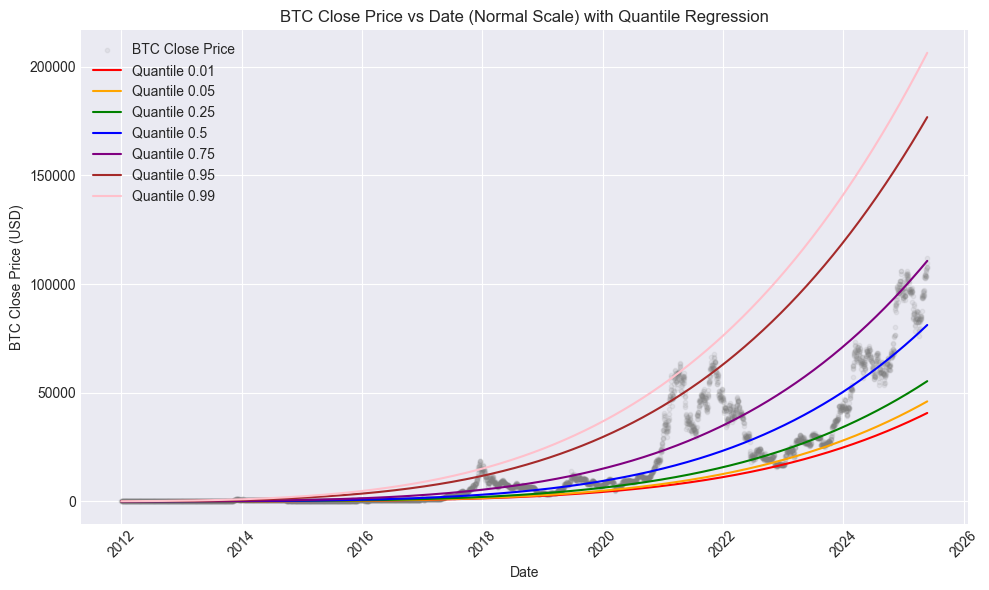

In [48]:
fig, ax = plt.subplots(figsize=(10, 6))
plt.style.use("seaborn-v0_8-darkgrid")

# Plot the actual data (normal scale)
ax.scatter(daily_df['Date'], daily_df['Close'], label='BTC Close Price', color='grey', alpha=0.1, s=10)

# Plot quantile regression lines (convert predictions back to normal scale)
for i, q in enumerate(quantiles):
    intercept = quantile_regression_results[str(q)]['intercept']
    slope = quantile_regression_results[str(q)]['slope']
    y_pred = np.exp(intercept + slope * daily_df['log_days_since_genesis'])
    ax.plot(daily_df['Date'], y_pred, label=f'Quantile {q}', color=quantile_colors[i % len(quantile_colors)])

ax.set_xlabel('Date')
ax.set_ylabel('BTC Close Price (USD)')
ax.set_title('BTC Close Price vs Date (Normal Scale) with Quantile Regression')
ax.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

### Detailed Quantiles 

We will now get quantiles between 0.01 to 0.99 with steps of 0.01

In [49]:
quantiles = np.arange(0.01, 1.00, 0.01)

In [50]:
quantile_regression_results = {}

for q in quantiles:
    # Fit the QuantReg model
    quant_reg_model = sm.QuantReg(Y, X_const).fit(q=q)
    
    # Store the parameters (intercept and slope)
    quantile_regression_results[str(q)] = {
        "intercept": quant_reg_model.params["const"],
        "slope": quant_reg_model.params["log_days_since_genesis"],
        "summary": quant_reg_model.summary().as_text() # Storing full summary for reference
    }

/Users/praveen/work/github/bitcoin-power-law/.venv/lib/python3.12/site-packages/statsmodels/regression/quantile_regression.py:191: IterationLimitWarning: Maximum number of iterations (1000) reached.
  warnings.warn("Maximum number of iterations (" + str(max_iter) +


We will now match each value to it closest quantile

In [52]:
# Compute predicted log_Close for each quantile at each day
log_close_preds = np.zeros((len(daily_df), len(quantiles)))
for idx, q in enumerate(quantiles):
    intercept = quantile_regression_results[str(q)]['intercept']
    slope = quantile_regression_results[str(q)]['slope']
    log_close_preds[:, idx] = intercept + slope * daily_df['log_days_since_genesis']

# Find the closest quantile for each day's actual log_Close
closest_quantile_indices = np.abs(log_close_preds - daily_df['log_Close'].values[:, None]).argmin(axis=1)
closest_quantiles = quantiles[closest_quantile_indices]

# Add the closest quantile as a new column
daily_df['closest_quantile'] = closest_quantiles

In [53]:
daily_df.tail()

,Date,Open,High,Low,Close,Volume,DaysSinceGenesis,log_Close,log_days_since_genesis,closest_quantile
4889,2025-05-21,106891.0,110730.0,106141.0,109682.0,2430.794137,5617,11.605341,8.633553,0.75
4890,2025-05-22,109696.0,112000.0,109252.0,111743.0,1375.740257,5618,11.623957,8.633731,0.77
4891,2025-05-23,111742.0,111816.0,106827.0,107329.0,1588.228626,5619,11.583654,8.633909,0.73
4892,2025-05-24,107319.0,109501.0,106908.0,107799.0,577.066806,5620,11.588024,8.634087,0.74
4893,2025-05-25,107798.0,108143.0,107363.0,107654.0,60.286168,5621,11.586678,8.634265,0.73


To model the cyclicity of bitcoin we add the number of days since last halving or genesis

In [54]:
# Define Bitcoin halving dates (source: https://en.bitcoin.it/wiki/Controlled_supply)
halving_dates = [
    pd.to_datetime("2009-01-09"),  # Bitcoin Genesis Block
    pd.to_datetime("2012-11-28"),
    pd.to_datetime("2016-07-09"),
    pd.to_datetime("2020-05-11"),
    pd.to_datetime("2024-04-19"),
    # Add future halving dates if needed
]

# Convert 'Date' column to datetime if not already
daily_df['Date'] = pd.to_datetime(daily_df['Date'])

# Find the most recent halving for each date
def days_since_last_halving(date):
    past_halvings = [d for d in halving_dates if d <= date]
    if past_halvings:
        last_halving = max(past_halvings)
        return (date - last_halving).days
    else:
        return (date - halving_dates[0]).days  # Before first halving

daily_df['days_since_last_halving'] = daily_df['Date'].apply(days_since_last_halving)

In [55]:
daily_df.head()

,Date,Open,High,Low,Close,Volume,DaysSinceGenesis,log_Close,log_days_since_genesis,closest_quantile,days_since_last_halving
0,2012-01-01,4.58,4.84,4.58,4.84,10.000000,728,1.576915,6.590301,0.59,1087
1,2012-01-02,4.84,5.00,4.84,5.00,10.100000,729,1.609438,6.591674,0.60,1088
2,2012-01-03,5.00,5.32,5.00,5.29,107.085281,730,1.665818,6.593045,0.61,1089
3,2012-01-04,5.29,5.57,4.93,5.57,107.233260,731,1.717395,6.594413,0.62,1090
4,2012-01-05,5.57,6.46,5.57,6.42,70.328742,732,1.859418,6.595781,0.68,1091


In [56]:
# Calculate 5p and 5n columns for daily_df
future_window = 7

# Get the Close price as numpy array for efficiency
close_prices = daily_df['Close'].values

# Initialize arrays
five_p = np.zeros(len(daily_df), dtype=bool)
five_n = np.zeros(len(daily_df), dtype=bool)

for i in range(len(daily_df) - future_window):
    future = close_prices[i+1:i+1+future_window]
    current = close_prices[i]
    # 5p: price increases by more than 5% anytime in next 7 days
    if np.any(future > current * 1.05):
        five_p[i] = True
    # 5n: price decreases by more than 5% anytime in next 7 days
    if np.any(future < current * 0.95):
        five_n[i] = True

# Add to dataframe
daily_df['5p'] = five_p
daily_df['5n'] = five_n

In [63]:
# Calculate the rolling (moving) quantile for the last 7 days using the 'closest_quantile' column
daily_df['moving_quantile_7d'] = daily_df['closest_quantile'].rolling(window=7, min_periods=1).mean()

In [64]:
daily_df.head()

,Date,Open,High,Low,Close,Volume,DaysSinceGenesis,log_Close,log_days_since_genesis,closest_quantile,days_since_last_halving,5p,5n,moving_quantile_7d
0,2012-01-01,4.58,4.84,4.58,4.84,10.000000,728,1.576915,6.590301,0.59,1087,True,False,0.590
1,2012-01-02,4.84,5.00,4.84,5.00,10.100000,729,1.609438,6.591674,0.60,1088,True,False,0.595
2,2012-01-03,5.00,5.32,5.00,5.29,107.085281,730,1.665818,6.593045,0.61,1089,True,False,0.600
3,2012-01-04,5.29,5.57,4.93,5.57,107.233260,731,1.717395,6.594413,0.62,1090,True,False,0.605
4,2012-01-05,5.57,6.46,5.57,6.42,70.328742,732,1.859418,6.595781,0.68,1091,True,False,0.620


In [65]:
daily_df.tail()

,Date,Open,High,Low,Close,Volume,DaysSinceGenesis,log_Close,log_days_since_genesis,closest_quantile,days_since_last_halving,5p,5n,moving_quantile_7d
4889,2025-05-21,106891.0,110730.0,106141.0,109682.0,2430.794137,5617,11.605341,8.633553,0.75,397,False,False,0.714286
4890,2025-05-22,109696.0,112000.0,109252.0,111743.0,1375.740257,5618,11.623957,8.633731,0.77,398,False,False,0.724286
4891,2025-05-23,111742.0,111816.0,106827.0,107329.0,1588.228626,5619,11.583654,8.633909,0.73,399,False,False,0.728571
4892,2025-05-24,107319.0,109501.0,106908.0,107799.0,577.066806,5620,11.588024,8.634087,0.74,400,False,False,0.734286
4893,2025-05-25,107798.0,108143.0,107363.0,107654.0,60.286168,5621,11.586678,8.634265,0.73,401,False,False,0.735714


We will now build a model to predict if the pricing will increase or decrease in the next 7 days. The parameters we use are current quantile, number of days since last halving and moving 7 days quantile. 

In [86]:
X= daily_df[['closest_quantile', 'days_since_last_halving', 'moving_quantile_7d']]
Y_p = daily_df['5p'].astype(int)  # Convert boolean to int for regression
Y_n = daily_df['5n'].astype(int)  # Convert boolean to int for regression

In [87]:
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier

In [88]:
scaler = StandardScaler()
X_standardized = scaler.fit_transform(X)

In [89]:
X_train, X_test, y_p5_train, y_p5_test = train_test_split(X_standardized, Y_p, test_size=0.3, random_state=42)
X_train, X_test, y_n5_train, y_n5_test = train_test_split(X_standardized, Y_n, test_size=0.3, random_state=42)

In [90]:
rf_p5 = RandomForestClassifier(random_state=42, max_depth=10, min_samples_split=5, min_samples_leaf=2, max_features='sqrt')
rf_p5.fit(X_train, y_p5_train)
rf_n5 = RandomForestClassifier(random_state=42, max_depth=10, min_samples_split=5, min_samples_leaf=2, max_features='sqrt')
rf_n5.fit(X_train, y_n5_train)

RandomForestClassifier(max_depth=10, min_samples_leaf=2, min_samples_split=5,
                       random_state=42)

In [91]:
# Calculate accuracy for Random Forest p5
rf_p5_train_accuracy = rf_p5.score(X_train, y_p5_train)
rf_p5_test_accuracy = rf_p5.score(X_test, y_p5_test)
print(f"Random Forest Training Accuracy for p5: {rf_p5_train_accuracy * 100:.2f}%")
print(f"Random Forest Test Accuracy for p5: {rf_p5_test_accuracy * 100:.2f}%")

# Calculate accuracy for Random Forest n5
rf_n5_train_accuracy = rf_n5.score(X_train, y_n5_train)
rf_n5_test_accuracy = rf_n5.score(X_test, y_n5_test)
print(f"Random Forest Training Accuracy for n5: {rf_n5_train_accuracy * 100:.2f}%")
print(f"Random Forest Test Accuracy for n5: {rf_n5_test_accuracy * 100:.2f}%")

Random Forest Training Accuracy for p5: 84.99%
Random Forest Test Accuracy for p5: 73.79%
Random Forest Training Accuracy for n5: 86.16%
Random Forest Test Accuracy for n5: 78.90%


In [92]:
last_nonscaled = X.iloc[-1:]
last_nonscaled

,closest_quantile,days_since_last_halving,moving_quantile_7d
4893,0.73,401,0.735714


In [98]:
print("Current Quantile:", last_nonscaled['closest_quantile'].values[0])

Current Quantile: 0.73


In [95]:
# Predict the last entry in X_standardized using all trained models
last_entry = X_standardized[-1].reshape(1, -1)

last_entry

array([[ 0.79719023, -0.68356167,  0.8195468 ]])

In [97]:


# Random Forest predictions
rf_p5_prediction = rf_p5.predict(last_entry)
rf_n5_prediction = rf_n5.predict(last_entry)
print(f"Prediction for price increaseing by 5% in the next week: {rf_p5_prediction[0]}")
print(f"Prediction for price decreaseing by 5% in the next week: {rf_n5_prediction[0]}")

Prediction for price increaseing by 5% in the next week: 1
Prediction for price decreaseing by 5% in the next week: 0
